In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns',None) # To display all columns
pd.set_option('display.max_rows',None) # To display all columns
import feather
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')
from functools import reduce

In [2]:
KT1 = pd.read_feather('DEMOKT1.ftr')
#KT3 = pd.read_feather('KT3.ftr')

In [3]:
questions_df = pd.read_csv('questions.csv')

In [4]:
KT1.head()

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_iD
0,1565096190868,1,q5012,b,38000,1
1,1565096221062,2,q4706,c,24000,1
2,1565096293432,3,q4366,b,68000,1
3,1565096339668,4,q4829,a,42000,1
4,1565096401774,5,q6528,b,59000,1


In [19]:
questions_df.bundle_id = questions_df.bundle_id.str.slice(start=1)
questions_df.explanation_id = questions_df.explanation_id.str.slice(start=1)
questions_df.deployed_at = pd.to_datetime(questions_df.deployed_at, unit='ms')
dfq = questions_df[['question_id', 'correct_answer', 'bundle_id', 'part', 'tags', 'deployed_at']]
dfq.head()

,question_id,correct_answer,bundle_id,part,tags,deployed_at
0,q1,b,,1,1;2;179;181,2019-05-17 11:40:17.098
1,q2,a,,1,15;2;182,2019-05-17 11:40:19.720
2,q3,b,,1,14;2;179;183,2019-05-17 11:40:22.784
3,q4,b,,1,9;2;179;184,2019-05-17 11:40:25.357
4,q5,c,,1,8;2;179;181,2019-05-17 11:40:28.439


In [20]:
# subset df for notnull question_id rows only (only work with rows that have questions)
df2 = K1[K1['question_id'].notnull()]

In [21]:
# left join student dataframe and answer key dataframe on the 'question_id' column 
dfm = pd.merge(df2, dfq,  how='left', left_on=['question_id'], right_on = ['question_id'])

In [22]:
# create a 'correct' column
dfm['correct'] = np.nan

# loop - if user answers == correct answer, then dfq['correct'][_]= 1
length_df = dfm['user_iD'].count()
count = 0
for i in range(length_df):
    if dfm['user_answer'][count] == dfm['correct_answer'][count]:
        dfm['correct'][count] = 1
    if dfm['user_answer'][count] != dfm['correct_answer'][count]:
        dfm['correct'][count] = 0
    count+=1

In [23]:
# inspect new merged dataframe
dfm.head()

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_iD,correct_answer,bundle_id,part,tags,deployed_at,correct
0,1565096190868,1,q5012,b,38000,1,c,544,5,74,2019-09-17 02:43:28.616,0.0
1,1565096221062,2,q4706,c,24000,1,c,238,5,71,2019-10-30 05:34:30.723,1.0
2,1565096293432,3,q4366,b,68000,1,b,898,5,103,2019-10-30 05:37:51.451,1.0
3,1565096339668,4,q4829,a,42000,1,c,361,5,83,2019-06-24 09:24:51.347,0.0
4,1565096401774,5,q6528,b,59000,1,d,060,5,90,2019-10-17 03:03:15.009,0.0


In [35]:
df_total_questions_attempted = dfm2.groupby(['user_iD'], as_index=False)['question_id'].count()

df_total_questions_attempted = df_total_questions_attempted.rename(columns={'question_id': 'Total Questions Attempted'})

df_total_questions_attempted.head()
                                                                   

,user_iD,Total Questions Attempted
0,1,1082
1,2,1103
2,4,2699
3,5,1233
4,7,1249


In [37]:
df_correct = dfm2[dfm2['user_correct']==1].groupby(['user_iD'], as_index=False)['question_id'].count()

df_correct = df_correct.rename(columns={'question_id': 'Corrected'})

df_correct.head()

,user_iD,Corrected
0,1,753
1,2,765
2,4,1932
3,5,754
4,7,808


In [38]:
df_incorrect = dfm2[dfm2['user_correct']==0].groupby(['user_iD'], as_index=False)['question_id'].count()

df_incorrect = df_incorrect.rename(columns={'question_id': 'InCorrected'})

df_incorrect.head()

,user_iD,InCorrected
0,1,329
1,2,338
2,4,767
3,5,479
4,7,441


In [39]:
df = pd.concat([df_total_questions_attempted, df_correct, df_incorrect], axis=1).fillna(0)
df.head()

,user_iD,Total Questions Attempted,user_iD,Corrected,user_iD,InCorrected
0,1,1082,1,753,1,329
1,2,1103,2,765,2,338
2,4,2699,4,1932,4,767
3,5,1233,5,754,5,479
4,7,1249,7,808,7,441


In [42]:
dfs = [df_total_questions_attempted, df_correct, df_incorrect]
df_final = reduce(lambda left,right: pd.merge(left,right,on='user_iD'), dfs)

In [44]:
df_final.head()

,user_iD,Total Questions Attempted,Corrected,InCorrected
0,1,1082,753,329
1,2,1103,765,338
2,4,2699,1932,767
3,5,1233,754,479
4,7,1249,808,441


In [46]:
df_final['Percentage'] = (df_final['Corrected'] / df_final['Total Questions Attempted']) *100
df_final.head()

,user_iD,Total Questions Attempted,Corrected,InCorrected,Percentage
0,1,1082,753,329,69.593346
1,2,1103,765,338,69.356301
2,4,2699,1932,767,71.582067
3,5,1233,754,479,61.151663
4,7,1249,808,441,64.691753


<AxesSubplot:xlabel='user_iD'>

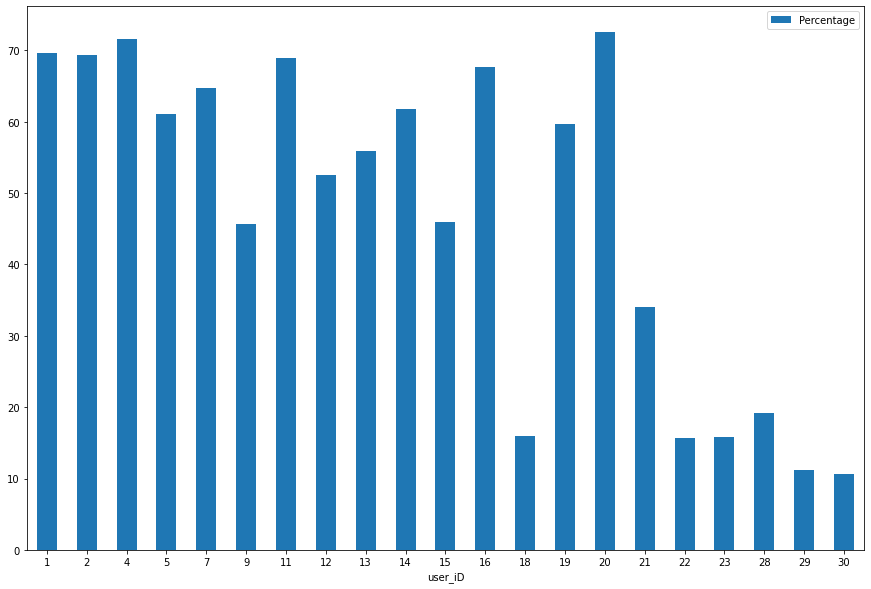

In [53]:
df_final.plot(x="user_iD", y=["Percentage"], kind="bar",figsize=(15,10) , rot=0)

In [55]:
A = df_final.loc[df_final['Percentage'] >= 50]

In [56]:
A.head()

,user_iD,Total Questions Attempted,Corrected,InCorrected,Percentage
0,1,1082,753,329,69.593346
1,2,1103,765,338,69.356301
2,4,2699,1932,767,71.582067
3,5,1233,754,479,61.151663
4,7,1249,808,441,64.691753


<AxesSubplot:xlabel='user_iD'>

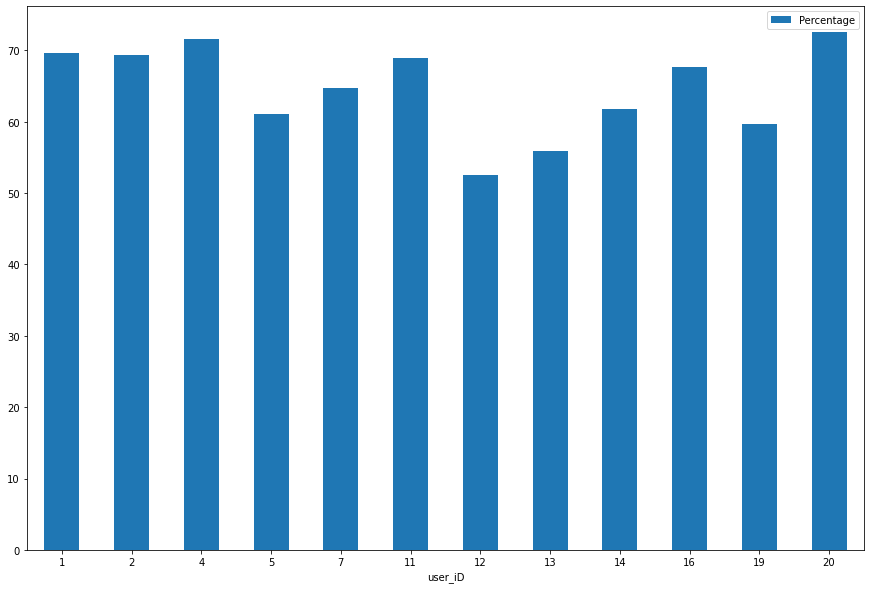

In [57]:
A.plot(x="user_iD", y=["Percentage"], kind="bar",figsize=(15,10) , rot=0)